Aparna Iyer

AI-ML A1

2022-2026

In [6]:
!pip install streamlit
!pip install lime
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import plot_model
import streamlit as st
import tensorflow.keras.backend as K
import shap
from lime import lime_image
from skimage.segmentation import mark_boundaries


  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=ba8cad56afa0eebdc86b70abab9d6e9b3fddada0e6e3ec7223a4605e200375e8
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [7]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define dataset path
data_dir = "/content/drive/MyDrive/The Wildfire Dataset"


Mounted at /content/drive


In [8]:
# Define dataset paths
data_dir = "/content/drive/MyDrive/The Wildfire Dataset"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")


# Image Preprocessing Function
def preprocess_image(image_path):
    image = load_img(image_path, target_size=(224, 224))  # Load image and resize
    image = img_to_array(image)  # Convert to array
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)  # Convert to HSV for better segmentation
    image = cv2.GaussianBlur(image, (5, 5), 0)  # Apply Gaussian Blurring to reduce noise
    image = image / 255.0  # Normalize pixel values
    return image

# Image preprocessing and augmentation
data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)


In [9]:
# Load dataset
train_data = data_gen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='binary')
val_data = data_gen.flow_from_directory(val_dir, target_size=(224, 224), batch_size=32, class_mode='binary')
test_data = data_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False)



Found 1402 images belonging to 2 classes.
Found 82 images belonging to 2 classes.
Found 420 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


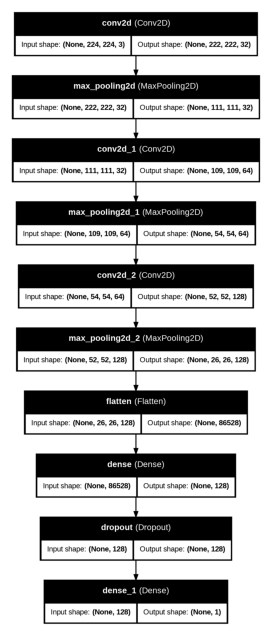

In [10]:
# Build CNN model
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Create the directory if it doesn't exist
os.makedirs("/mnt/data/", exist_ok=True)

# Generate and save the model architecture visualization
plot_model(model, to_file="/mnt/data/cnn_architecture.png", show_shapes=True, show_layer_names=True)

# Display the generated image
img = plt.imread("/mnt/data/cnn_architecture.png")
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.show()



In [12]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_data, validation_data=val_data, epochs=10)



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
15/44 ━━━━━━━━━━━━━━━━━━━━ 7:51 16s/step - accuracy: 0.4988 - loss: 1.3724

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


26/44 ━━━━━━━━━━━━━━━━━━━━ 4:48 16s/step - accuracy: 0.4966 - loss: 1.1945

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


44/44 ━━━━━━━━━━━━━━━━━━━━ 767s 17s/step - accuracy: 0.5029 - loss: 1.0454 - val_accuracy: 0.2927 - val_loss: 0.8340
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 488s 11s/step - accuracy: 0.5274 - loss: 0.6928 - val_accuracy: 0.7317 - val_loss: 0.6788
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 491s 11s/step - accuracy: 0.6172 - loss: 0.6532 - val_accuracy: 0.6463 - val_loss: 0.6440
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 502s 11s/step - accuracy: 0.7103 - loss: 0.5638 - val_accuracy: 0.7805 - val_loss: 0.5745
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 496s 11s/step - accuracy: 0.7071 - loss: 0.5664 - val_accuracy: 0.8049 - val_loss: 0.5765
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 486s 11s/step - accuracy: 0.7140 - loss: 0.5667 - val_accuracy: 0.7927 - val_loss: 0.5202
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 487s 11s/step - accuracy: 0.7306 - loss: 0.5546 - val_accuracy: 0.7683 - val_loss: 0.5903
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 484s 11s/step - accuracy: 0.7411 - loss: 0.5458 - val_accuracy: 0.7439 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 5/14 ━━━━━━━━━━━━━━━━━━━━ 2:09 14s/step - accuracy: 0.8504 - loss: 0.4368

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (96631920 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (94487082 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


 6/14 ━━━━━━━━━━━━━━━━━━━━ 2:13 17s/step - accuracy: 0.8441 - loss: 0.4436

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (101859328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 257s 19s/step - accuracy: 0.7806 - loss: 0.4908
Test Accuracy: 71.43%
14/14 ━━━━━━━━━━━━━━━━━━━━ 141s 10s/step
              precision    recall  f1-score   support

           0       0.62      0.88      0.73       169
           1       0.89      0.65      0.75       251

    accuracy                           0.74       420
   macro avg       0.75      0.76      0.74       420
weighted avg       0.78      0.74      0.74       420



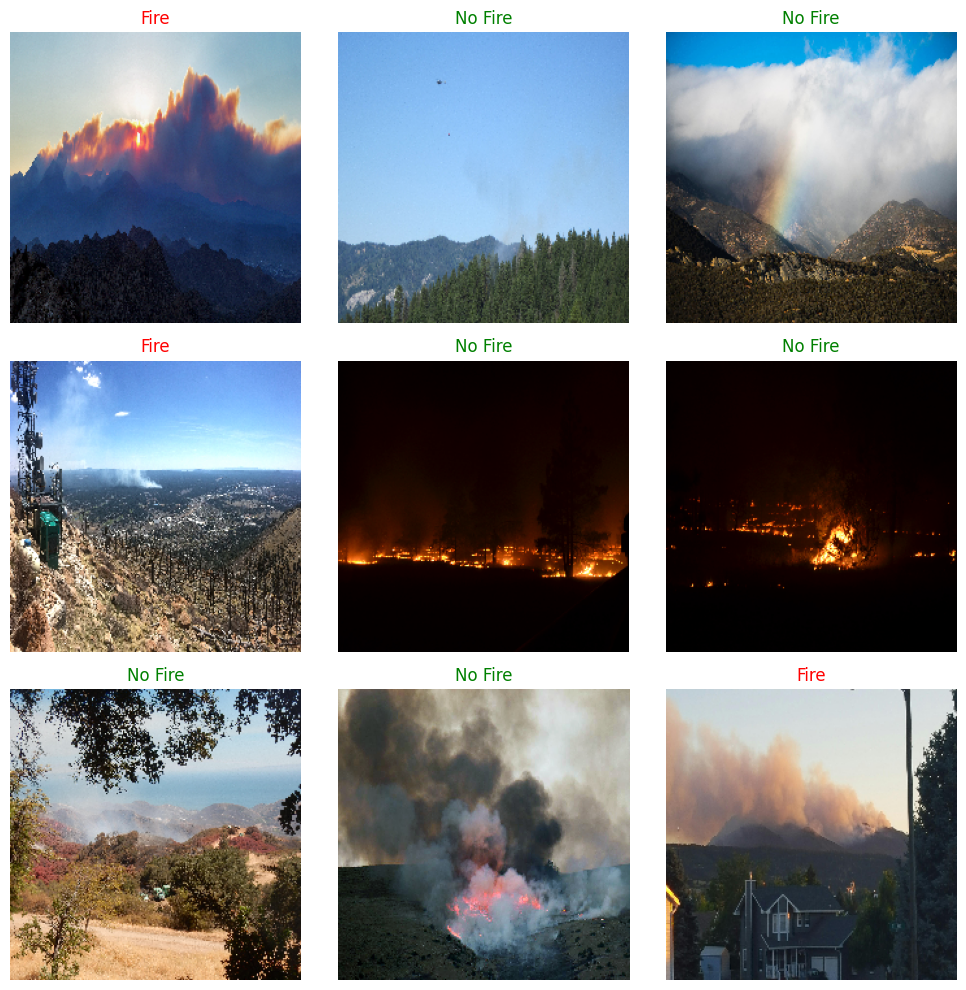

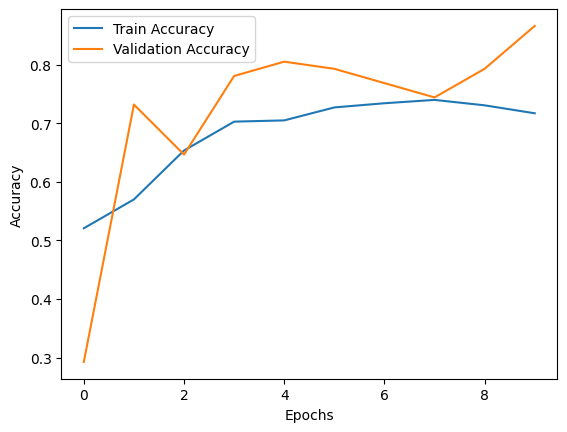

In [13]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Generate classification report
y_pred = model.predict(test_data)
y_pred = (y_pred > 0.5).astype(int)
y_true = test_data.classes
print(classification_report(y_true, y_pred))

# Visualize detected wildfires
def visualize_predictions(test_data, y_pred):
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.flatten()
    for i in range(9):
        img_path = test_data.filepaths[i]
        img = load_img(img_path, target_size=(224, 224))
        img = img_to_array(img) / 255.0
        axes[i].imshow(img)
        label = "Fire" if y_pred[i] == 1 else "No Fire"
        axes[i].set_title(label, fontsize=12, color='red' if y_pred[i] == 1 else 'green')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

visualize_predictions(test_data, y_pred)

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Save model
model.save("wildfire_detector.h5")


In [2]:
pip install gradio


In [14]:
import gradio as gr
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from skimage.segmentation import mark_boundaries

# Load your trained model
model = load_model("wildfire_detector.h5")

# Image preprocessing function
def preprocess_image(image):
    image = cv2.resize(image, (224, 224))
    image = np.expand_dims(image, axis=0) / 255.0
    return image

# Grad-CAM function (simplified for visualization)
def grad_cam(model, image):
    # Assuming last conv layer is named 'conv5_block3_out'
    last_conv_layer = model.get_layer("conv5_block3_out")
    grad_model = tf.keras.models.Model([model.input], [last_conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap[0]

# SHAP & LIME
# SHAP function for Explainable AI
def shap_explanation(model, image):
    explainer = shap.GradientExplainer(model, image)
    shap_values = explainer.shap_values(image)
    shap.image_plot(shap_values, image)

# LIME function for Explainable AI
def lime_explanation(model, image):
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(image[0].astype('double'), model.predict, top_labels=1, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)
    return temp, mask

# Prediction function for Gradio
def predict_fire(image):
    # Preprocess the uploaded image
    image_resized = preprocess_image(image)

    # Get model prediction
    prediction = model.predict(image_resized)
    label = "🔥 Fire Detected" if prediction[0][0] > 0.5 else "✅ No Fire"

    confidence = float(prediction[0][0])
    print(f"Prediction: {label} Confidence: {confidence:.2f}")

    # Generate Grad-CAM heatmap
    heatmap = grad_cam(model, image_resized)
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Overlay heatmap on original image
    img = cv2.resize(image, (224, 224))
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    # Generate explanations
    shap_text = shap_explanation(model, image_resized)
    lime_text = lime_explanation(model, image_resized)

    return label, superimposed_img, shap_text, lime_text

# Gradio Interface
iface = gr.Interface(
    fn=predict_fire,
    inputs=gr.Image(type="numpy"),
    outputs=[
        gr.Textbox(label="Prediction"),
        gr.Image(label="Grad-CAM Heatmap"),
        gr.Textbox(label="SHAP Explanation"),
        gr.Textbox(label="LIME Explanation")
    ],
    title="🔥 Wildfire Detection App",
    description="Upload an image to classify whether it contains a wildfire or not.",
)

# Launch the app
iface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8c51fce1e187c90b44.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
